In [149]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime as dt
from warnings import filterwarnings
filterwarnings('ignore')

In [150]:
def parser(s):
    return dt.strptime(s,'%Y-%m-%d')

# ----------------------Ice Cream Dataset----------------------

In [151]:
df= pd.read_csv(r"D:\Datasets\ice_cream.csv")

In [152]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [153]:
# lets rename the column names

df.rename(columns={'DATE':'Date','IPN31152N': 'Sales'}, inplace= True)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    577 non-null    object 
 1   Sales   577 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [155]:
df.head()

,Date,Sales
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [156]:
# convert date column to datetime format
df['Date']= pd.to_datetime(df['Date'])

In [157]:
# set date as index
df.set_index('Date', inplace= True)

In [158]:
df.head()

,Sales
Date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [159]:
df.index.year.unique()

Index([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020],
      dtype='int32', name='Date')

In [160]:
# we will only take the from 2010 onwards
start_date= pd.to_datetime('2010-01-01')
df_ic= df[start_date:]

In [161]:
df_ic.head()

,Sales
Date,
2010-01-01,91.2895
2010-02-01,110.4994
2010-03-01,127.0971
2010-04-01,132.6468
2010-05-01,134.5576


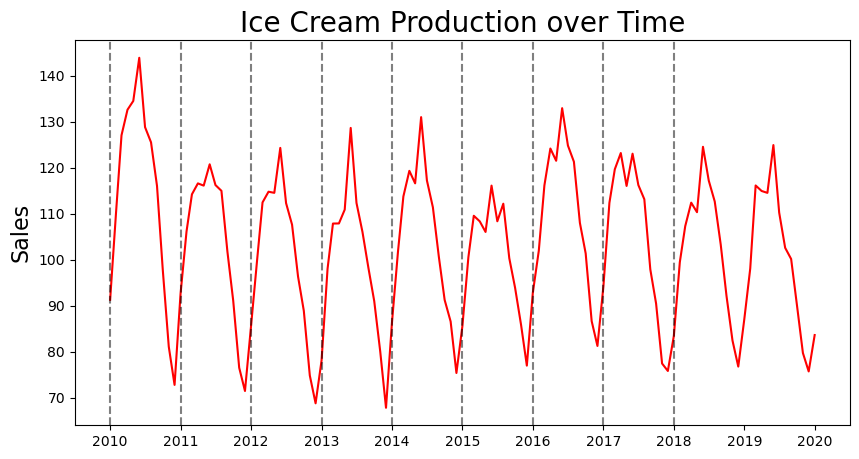

In [162]:
plt.figure(figsize=(10,5))
plt.plot(df_ic['Sales'], color= 'red')
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2010, 2019):
    plt.axvline(dt(year, 1, 1), linestyle= '--', color= 'k', alpha= 0.5)

In [163]:
# Normalize

avg, std= df_ic['Sales'].mean(), df_ic['Sales'].std()

In [164]:
df_ic_norm= (df_ic['Sales'] - avg)/std

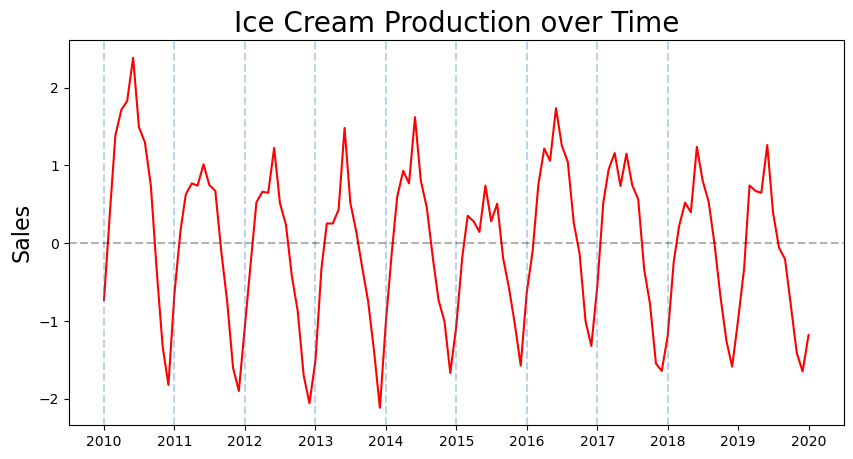

In [165]:
plt.figure(figsize=(10,5))
plt.plot(df_ic_norm, color= 'red')
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2010, 2019):
    plt.axvline(dt(year, 1, 1), linestyle= '--', alpha= 0.3)

plt.axhline(0, linestyle='--', color='k', alpha=0.3)

### What Is a Stationary Time Series?

A Stationary series is one whose statistical properties such as mean, variance, covariance, and standard deviation do not vary with time, or these stats properties are not a function of time. In other words, stationarity in Time Series also means series without a Trend or Seasonal components.

#### Why Should Time Series Be Stationary?

Stationary series is easier for statistical models to predict effectively and precisely.

## #ADF

ADF test is conducted with the following assumptions:

    Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
    Alternate Hypothesis(HA): Series is stationary, or series has no unit root.


If T-statistic < critical value or p-value < 0.05 reject H0 i.e series is stationary 

In [166]:
# Check Stationary or not using ADF

def adf_test(series):
    result= adfuller(series)
    print(f'ADF Statistics:{result[0]}')
    print(f'p-value:{result[1]}')

In [167]:
adf_test(df_ic_norm)

ADF Statistics:-3.4692068038611503
p-value:0.008814055324486834


In [168]:
# Here we can see that our data is stationary 

## ACF

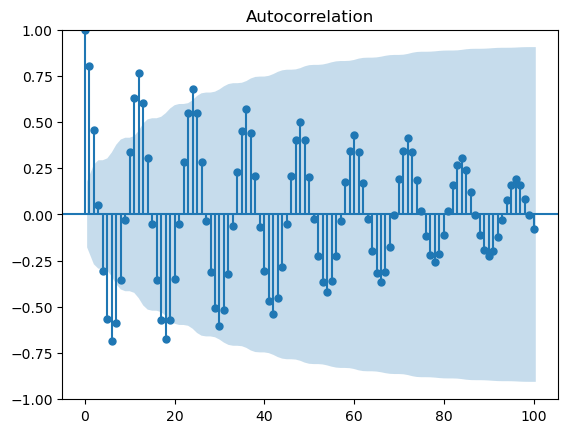

In [169]:
series= plot_acf(df_ic_norm, lags= 100)

In [170]:
# We can see that we have diminishing type of lags, whcih says that we have AR type of data, i.e because the current value 
# is depending on the it one lagged value


## Autoregressive (AR) Model:

    The Autoregressive model is based on the idea that future values in a time series can be predicted based on past values.
    In an AR model, each value in the time series is modeled as a linear combination of its own past values (lags).
    The AR model captures long-term dependencies and patterns in the data, where the forecast at each time step depends on the previous observed values.
    The order of the AR model (denoted as p) represents the number of past observations (lags) used in the forecasting equation.

For AR model we will be calculating PACF, to choose the lags for AR

### PACF

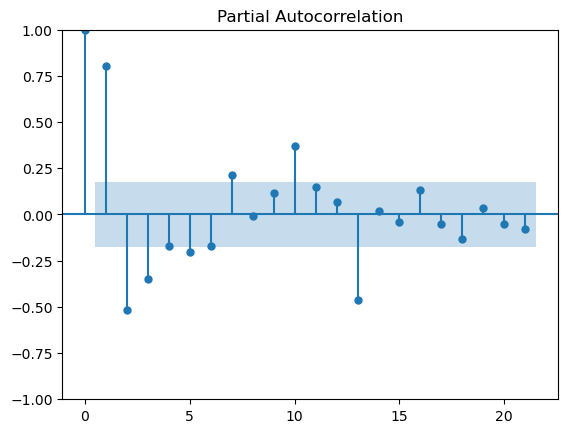

In [171]:
pacf= plot_pacf(df_ic_norm)

In [172]:
# From above graph, lag 1, 2, 3, 10 and 13 looks more significant lags to start our AR process

### Model Selection:

how to select which lag to use 

In [173]:
import statsmodels.api as st

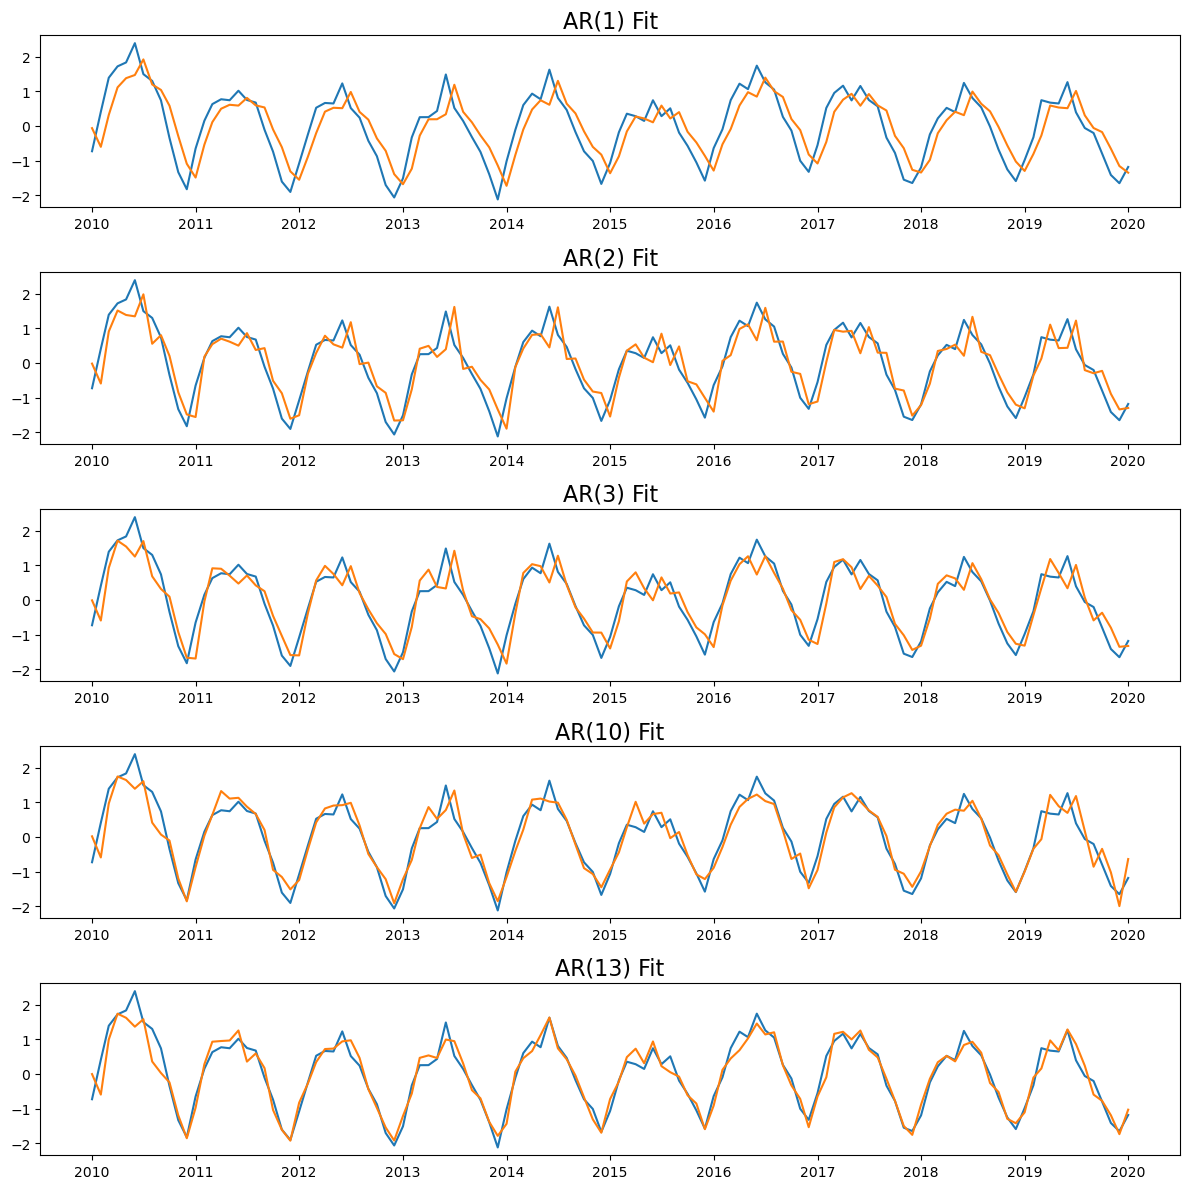

In [174]:
plt.figure(figsize=(12,12))
ar_order= [1,2,3,10,13]
fitted_mod_dict= {}

for idx, ar in enumerate(ar_order):
    
    # create AR(p) model
    ar_model= st.tsa.ARIMA(df_ic_norm, order= (ar,0, 0))
    ar_model_fit= ar_model.fit()
#     print(ar_model_fit.aic)

    fitted_mod_dict[ar]= ar_model_fit
    
#     print(fitted_mod_dict)
    plt.subplot(5,1, idx+1)
    plt.plot(df_ic_norm)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar, fontsize=16)
 

plt.tight_layout()

In [175]:
# from the above graphs it seems that lag of 1 and 13 are good choices and fits well with the data, but lets have a deeper look in it

### AIC vs BIC 

AIC and BIC criterias helps to find the most significant lag value

Lower AIC via higher log likelihood or less parameters

Lower BIC via higher log likelihood or less parameters or less samples used in fitting

In [176]:
# AIC comparision in ar order
for ar in ar_order:
    print(f'AIC for AR {ar}: {fitted_mod_dict[ar].aic}')

AIC for AR 1: 220.95622650268118
AIC for AR 2: 181.03662397962805
AIC for AR 3: 163.43420129405555
AIC for AR 10: 114.8212268547861
AIC for AR 13: 45.68677455750385


In [177]:
# lower the AIC, best the lag parameter to use.Which means we will should go with lag 13

In [178]:
# BIC comparision in ar order

for ar in ar_order:
    print(f'BIC for AR {ar}: {fitted_mod_dict[ar].bic}')

BIC for AR 1: 229.3435981394714
BIC for AR 2: 192.219786162015
BIC for AR 3: 177.41315402203927
BIC for AR 10: 148.370713401947
BIC for AR 13: 87.62363274145497


In [179]:
# BIC makes it more strong that we should use lag 13

In [180]:
# train test split 
train_end= dt(2019, 11, 30)
test_start= dt(2019, 12, 1)

train_data= df_ic_norm[:train_end]
test_data= df_ic_norm[test_start:]

In [181]:
train_data.shape, test_data.shape

((119,), (2,))

In [182]:
train_data

Date
2010-01-01   -0.728216
2010-02-01    0.407478
2010-03-01    1.388738
2010-04-01    1.716838
2010-05-01    1.829805
                ...   
2019-07-01    0.393514
2019-08-01   -0.059034
2019-09-01   -0.202956
2019-10-01   -0.794495
2019-11-01   -1.412071
Name: Sales, Length: 119, dtype: float64

In [183]:
# create the model
ar_model= st.tsa.ARIMA(train_data, order=(13,0, 0))


In [184]:
# fit the model
ar_model_fit= ar_model.fit()

In [185]:
# summary of the model
ar_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  119
Model:                ARIMA(13, 0, 0)   Log Likelihood                  -8.536
Date:                Fri, 15 Mar 2024   AIC                             47.073
Time:                        10:47:53   BIC                             88.760
Sample:                    01-01-2010   HQIC                            64.000
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.256e-05      0.096      0.000      1.000      -0.189       0.189
ar.L1          0.8492      0.072     11.867      0.000       0.709       0.989
ar.L2          0.0077      0.099      0.077      0.938      -0.187       0.202
ar.L3         -0.1129      0.096     -1.173      0.241      -0.301       0.076
ar.L4         -0.0007      0.104     -0.007      0.994      -0.205       0.204
ar.L5          0.0578      0.114      0.506      0.613      -0.166       0.281
ar.L6         -0.1643      0.094     -1.747      0.081      -0.349       0.020
ar.L7          0.0574      0.107      0.538      0.591      -0.152       0.267
ar.L8          0.0118      0.112      0.105      0.916      -0.208       0.232
ar.L9         -0.0994      0.093     -1.067      0.286      -0.282       0.083
ar.L10         0.0175      0.085      0.205      0.838      -0.150       0.185
ar.L11         0.0845      0.103      0.824      0.410      -0.117       0.285
ar.L12         0.7036      0.100      7.062      0.000       0.508       0.899
ar.L13        -0.6815      0.076     -8.968      0.000      -0.830      -0.533
sigma2         0.0588      0.010      5.868      0.000       0.039       0.078
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):                 5.32
Prob(Q):                              0.25   Prob(JB):                         0.07
Heteroskedasticity (H):               0.92   Skew:                             0.51
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [186]:
# get the start and end date for prediction

pred_start_date= test_data.index[0]
pred_end_date= test_data.index[-1]

pred_start_date, pred_end_date

(Timestamp('2019-12-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

In [187]:
# get prediction and residual

predictions= ar_model_fit.predict(start= pred_start_date, end= pred_end_date)


In [188]:
predictions

2019-12-01   -1.748097
2020-01-01   -1.083876
Freq: MS, Name: predicted_mean, dtype: float64

In [189]:
# calculate the residual

residual = test_data- predictions

In [190]:
residual

Date
2019-12-01    0.098782
2020-01-01   -0.097230
dtype: float64

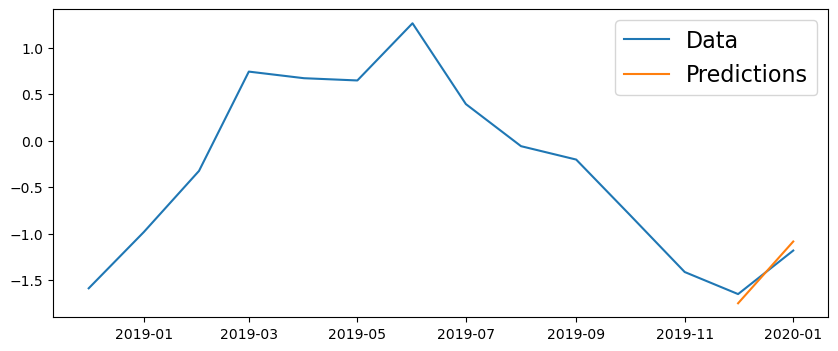

In [191]:
plt.figure(figsize=(10,4))
plt.plot(df_ic_norm[-14:])
plt.plot(predictions)


plt.legend(('Data', 'Predictions'), fontsize=16)

In [192]:
# evaluate using mean abs perc error
print(f'Mean Absolute Percent Error:{np.round(np.mean(np.abs(residual/test_data)),4)}')

Mean Absolute Percent Error:0.0711


In [193]:
# evaluate using root mean squared error
print(f'Root Mean Squared Error:{np.round(np.sqrt(np.mean(residual**2)),4)}')

Root Mean Squared Error:0.098


## Moving Average (MA) Model:

    The Moving Average model is based on the idea of averaging past observations to forecast future values.
    In an MA model, each value in the time series is modeled as a linear combination of past observation errors (residuals).
    The MA model captures short-term dependencies between observations, with the forecast at each time step being a weighted sum of the most recent past observations.

ACF is mostly used to choose the lag for MA model

<BarContainer object of 14 artists>

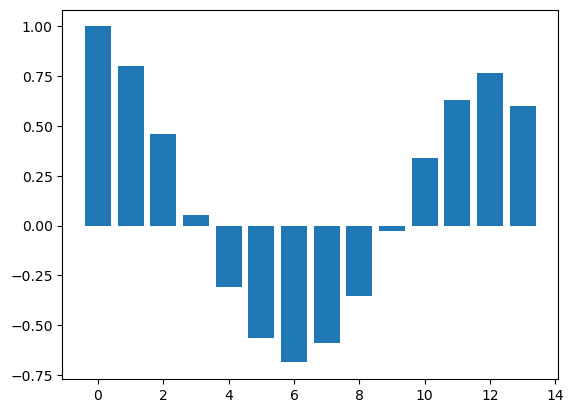

In [194]:
# Plot ACF
acf_value= acf(df_ic_norm)
num_lags= 14
plt.bar(range(num_lags), acf_value[:num_lags])

<BarContainer object of 14 artists>

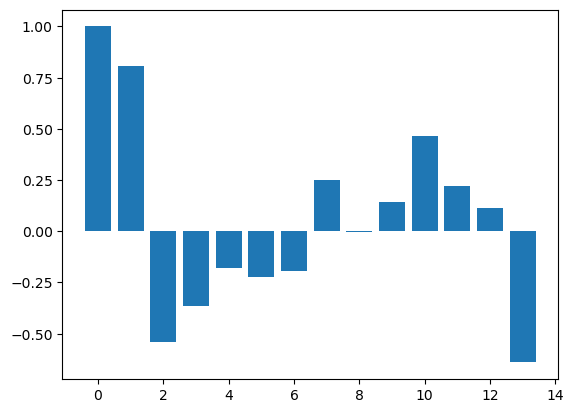

In [195]:
from statsmodels.tsa.stattools import pacf as pf
#plot pacf

pacf_val= pf(df_ic_norm)
num_lags= 14
plt.bar(range(num_lags), pacf_val[:num_lags])

In [196]:
# we will go with lag 1
ma_model= st.tsa.ARIMA(train_data, order= (0,0,2))

In [197]:
# fit the model
ma_model_fit= ma_model.fit()

In [198]:
# summary of model
ma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  119
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 -95.081
Date:                Fri, 15 Mar 2024   AIC                            198.162
Time:                        10:47:54   BIC                            209.279
Sample:                    01-01-2010   HQIC                           202.676
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.136     -0.018      0.986      -0.270       0.265
ma.L1          0.9876      0.070     14.010      0.000       0.849       1.126
ma.L2          0.7148      0.064     11.110      0.000       0.589       0.841
sigma2         0.2850      0.043      6.693      0.000       0.202       0.368
===================================================================================
Ljung-Box (L1) (Q):                   4.94   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.03   Prob(JB):                         0.58
Heteroskedasticity (H):               0.88   Skew:                            -0.03
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
# predict the model
ma_pred= ma_model_fit.predict(pred_start_date, pred_end_date)

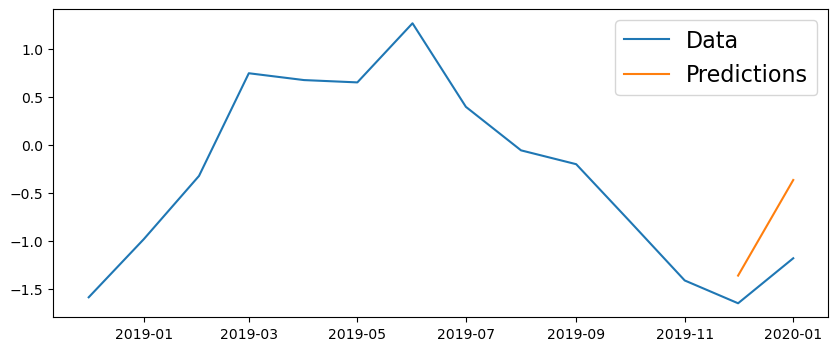

In [200]:
plt.figure(figsize=(10,4))
plt.plot(df_ic_norm[-14:])
plt.plot(ma_pred)


plt.legend(('Data', 'Predictions'), fontsize=16)

In [201]:
# calculate the residual

residual = test_data - ma_pred

In [202]:
# evaluate using mean abs perc error
print(f'Mean Absolute Percent Error:{np.round(np.mean(np.abs(residual/test_data)),4)}')

Mean Absolute Percent Error:0.4318


In [203]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual**2)))

Root Mean Squared Error: 0.6103440657592913


In [204]:
# we can see that randomly peeking lag, is not giving a good result. Lets try with AIC

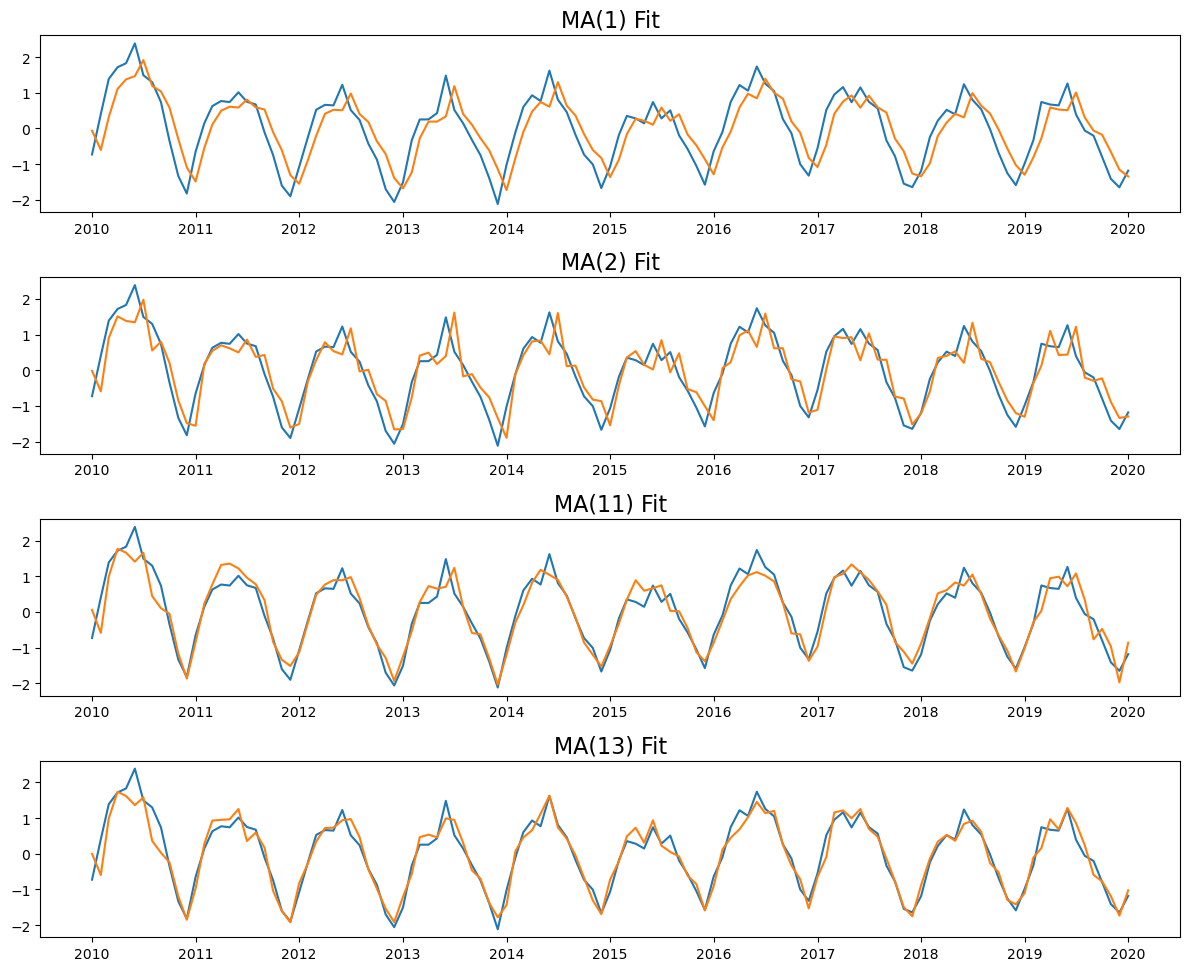

In [205]:
plt.figure(figsize=(12,12))
ma_order= [1,2,11,13]
fitted_mod_dict= {}

for idx, ma in enumerate(ma_order):
    
    # create AR(p) model
    ma_model= st.tsa.ARIMA(df_ic_norm, order= (ma,0, 0))
    ma_model_fit= ma_model.fit()
#     print(ar_model_fit.aic)

    fitted_mod_dict[ma]= ma_model_fit
    
#     print(fitted_mod_dict)
    plt.subplot(5,1, idx+1)
    plt.plot(df_ic_norm)
    plt.plot(ma_model_fit.fittedvalues)
    plt.title('MA(%s) Fit'%ma, fontsize=16)
 

plt.tight_layout()

In [206]:
# AIC comparision in ar order

for ma in ma_order:
    print(f'AIC for AR {ma}: {fitted_mod_dict[ma].aic}')

AIC for AR 1: 220.95622650268118
AIC for AR 2: 181.03662397962805
AIC for AR 11: 107.53529246380604
AIC for AR 13: 45.68677455750385


In [207]:
# we will go with lag 1
ma_model= st.tsa.ARIMA(train_data, order= (0,0,13))
ma_model_fit= ma_model.fit()
ma_pred= ma_model_fit.predict(pred_start_date, pred_end_date)

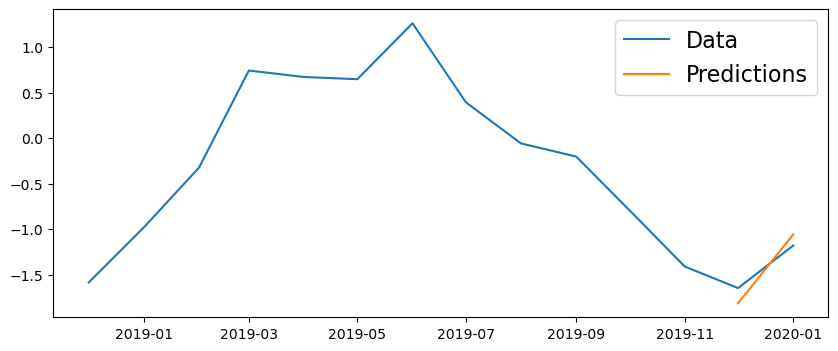

In [208]:
plt.figure(figsize=(10,4))
plt.plot(df_ic_norm[-14:])
plt.plot(ma_pred)


plt.legend(('Data', 'Predictions'), fontsize=16)

In [209]:
# Not bad, using lag 13 we are getting quite good a prediction

# calculate the residual

residual = test_data - ma_pred

In [210]:
residual

Date
2019-12-01    0.167042
2020-01-01   -0.121805
dtype: float64

In [211]:
# evaluate using mean abs perc error
print(f'Mean Absolute Percent Error:{np.round(np.mean(np.abs(residual/test_data)),4)}')

Mean Absolute Percent Error:0.1022


In [212]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual**2)))

Root Mean Squared Error: 0.1461839490377441


## ARMA (Autoregressive Moving Average):

ARMA is a simpler model that combines autoregressive (AR) and moving average (MA) components without differencing.
The ARMA model is denoted as ARMA(p, q), where:
    
    # p represents the order of the autoregressive (AR) component, indicating the number of lagged observations included           in the model.
    # q represents the order of the moving average (MA) component, indicating the number of lagged forecast errors                 included in the model.
        
ARMA models are suitable for stationary time series data that exhibit autocorrelation but do not have trends or             seasonality. 

In [213]:
# As our data dont have trend and seasonality so we are using ARMA model

In [214]:
# lets use some easy lags for AR and MA like lag= 3 for AR and  lag=2 for MA model 
arma_model= st.tsa.ARIMA(train_data, order= (3, 0, 2))
arma_model_fit= arma_model.fit()

In [215]:
# summary
arma_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  119
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -59.412
Date:                Fri, 15 Mar 2024   AIC                            132.824
Time:                        10:47:58   BIC                            152.278
Sample:                    01-01-2010   HQIC                           140.724
                         - 11-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0301      0.123      0.244      0.807      -0.211       0.271
ar.L1          2.5020      0.066     37.802      0.000       2.372       2.632
ar.L2         -2.3329      0.116    -20.157      0.000      -2.560      -2.106
ar.L3          0.7760      0.068     11.397      0.000       0.643       0.909
ma.L1         -1.7872      0.079    -22.583      0.000      -1.942      -1.632
ma.L2          0.9655      0.085     11.301      0.000       0.798       1.133
sigma2         0.1630      0.032      5.169      0.000       0.101       0.225
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 2.94
Prob(Q):                              0.66   Prob(JB):                         0.23
Heteroskedasticity (H):               0.73   Skew:                             0.28
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
# predict the model

arma_pred= arma_model_fit.predict(pred_start_date, pred_end_date)

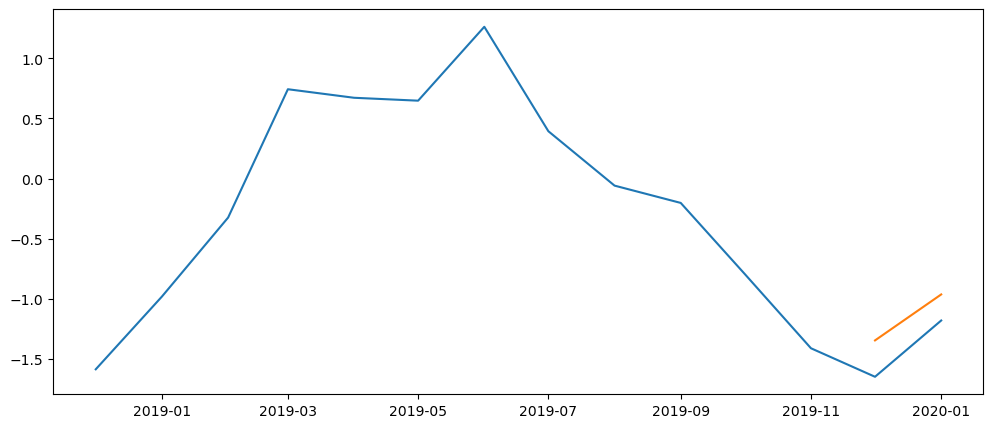

In [217]:
plt.figure(figsize=(12,5))
plt.plot(df_ic_norm[-14:])
plt.plot(arma_pred)

In [218]:
# calculate the residual

residual = test_data - arma_pred

In [219]:
# evaluate using mean abs perc error
print(f'Mean Absolute Percent Error:{np.round(np.mean(np.abs(residual/test_data)),4)}')

Mean Absolute Percent Error:0.1835


In [220]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual**2)))

Root Mean Squared Error: 0.26317875015170195


### ARIMA (Autoregressive Integrated Moving Average):

ARIMA is a more generalized model that incorporates both autoregressive (AR) and moving average (MA) components, along with differencing to handle non-stationarity.

The ARIMA model is denoted as ARIMA(p, d, q), where:

     # p represents the order of the autoregressive (AR) component, indicating the number of lagged observations included          in the model.
     
     # d represents the degree of differencing needed to make the time series stationary. Differencing involves computing          the difference between consecutive observations to remove trends or seasonality.
     
     # q represents the order of the moving average (MA) component, indicating the number of lagged forecast errors                included in the model.

ARIMA models are suitable for time series data that exhibit trends, seasonality, or other forms of non-stationarity.

# ---------------------------------Cat Fish DataSet-------------------

In [221]:
# As our ice cream data dont have trend or seasonality so, lets use some other data to test ARIMA model

In [222]:
df_cat_sales= pd.read_csv(r"D:\Datasets\catfish.csv", parse_dates= [0], date_parser= parser, index_col=[0])

In [223]:
df_cat_sales.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


In [224]:
df_cat_sales.shape

(324, 1)

In [225]:
df_cat_sales.index.year.unique()

Index([1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012],
      dtype='int32', name='Date')

In [226]:
# infer the frequency of the data
df_cat_sales= df_cat_sales.asfreq(pd.infer_freq(df_cat_sales.index))

In [227]:
df_cat_sales.tail()

,Total
Date,
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795
2012-11-01,13352
2012-12-01,12716


In [228]:
start_date = dt(1996,1,1)
end_date = dt(2000,1,1)

df_cat = df_cat_sales[start_date:end_date]

In [229]:
df_cat.shape

(49, 1)

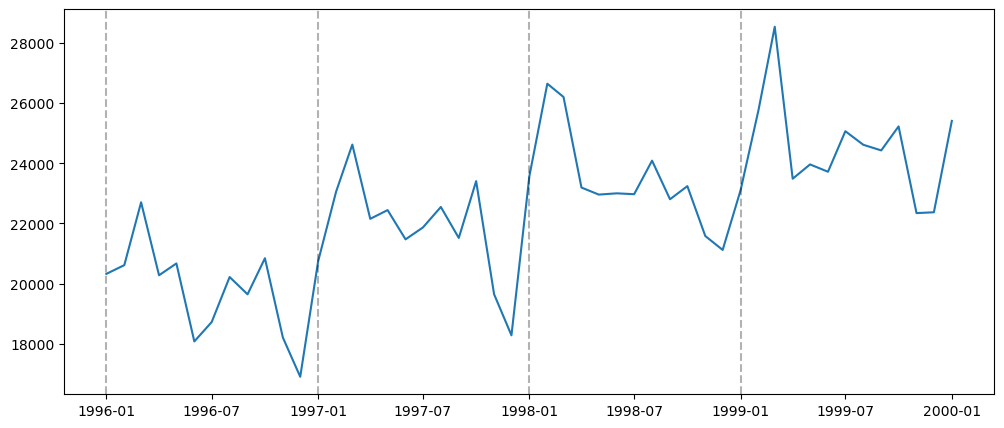

In [230]:
plt.figure(figsize=(12,5))
plt.plot(df_cat)

for year in range(df_cat.index.year[0], df_cat.index.year[-1]):
    
    plt.axvline(dt(year,1,1), linestyle='--', color= 'k', alpha= 0.3)

In [231]:
# we can see that the graph has some kind of pattern in it, which means its not stationary

In [232]:
adf= adfuller(df_cat)

In [233]:
print(f'ADF: {adf[0]}, p-value: {adf[1]}')

ADF: -2.3427163739083685, p-value: 0.15856082643053904


In [234]:
# ADF test shows that p-value is > 0.5 which means we accepts the H0 i.e the data is not- staionary

### Remove the Trend (Stationary)

In [235]:
df_cat= df_cat.diff().dropna()

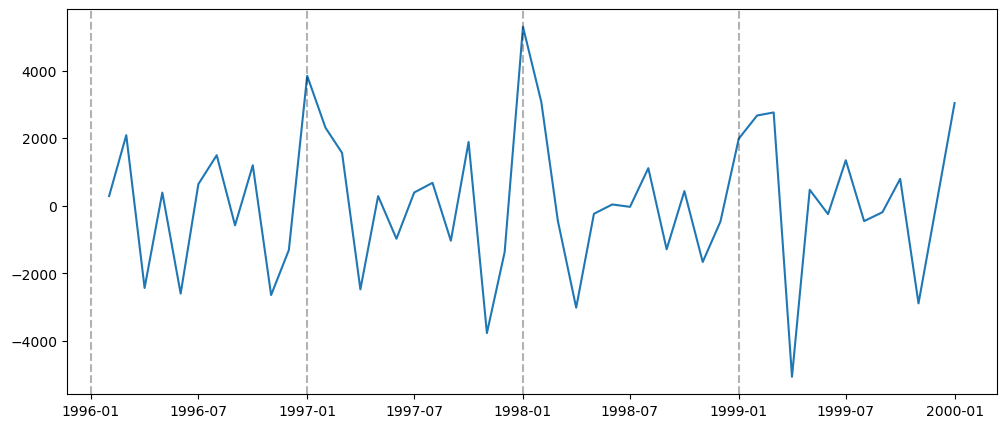

In [236]:
plt.figure(figsize=(12,5))
plt.plot(df_cat)

for year in range(df_cat.index.year[0], df_cat.index.year[-1]):
    
    plt.axvline(dt(year,1,1), linestyle='--', color= 'k', alpha= 0.3)

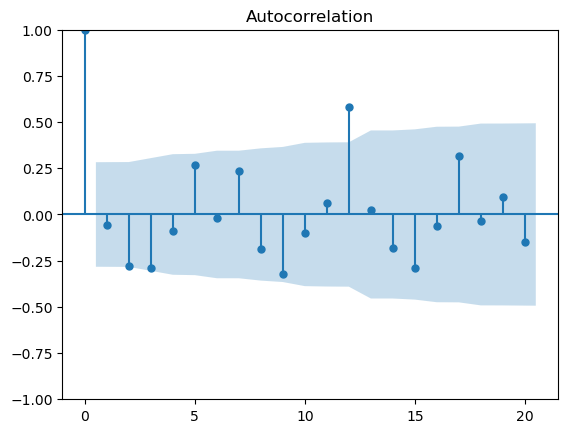

In [237]:
# Plot ACF
acf= plot_acf(df_cat, lags= 20)

In [238]:
# As per ACF we should start with lag= 3 

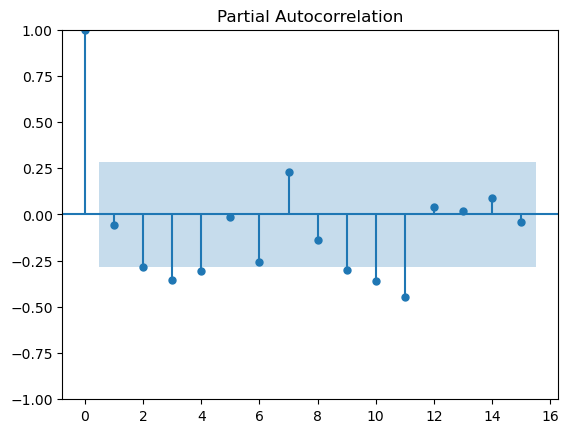

In [239]:
# plot PACF

pacf= plot_pacf(df_cat, lags= 15)

In [240]:
# and for MA we should start with lag= 4

In [241]:
# train test split
train_end= dt(1999, 7, 1)
test_end= dt(2000, 1 , 1)

In [242]:
from datetime import timedelta

train_cat= df_cat[:train_end]
test_cat= df_cat[train_end : test_end]

In [243]:
train_cat.shape, test_cat.shape

((42, 1), (7, 1))

In [244]:
test_cat

,Total
Date,
1999-07-01,1349.0
1999-08-01,-451.0
1999-09-01,-188.0
1999-10-01,799.0
1999-11-01,-2885.0
1999-12-01,28.0
2000-01-01,3040.0


In [245]:
# create the model

arima_model= st.tsa.ARIMA(train_cat, order= (3, 1, 4))

In [246]:
# fit the model

arima_fit= arima_model.fit()

In [247]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -367.310
Date:                Fri, 15 Mar 2024   AIC                            750.621
Time:                        10:47:59   BIC                            764.329
Sample:                    02-01-1996   HQIC                           755.613
                         - 07-01-1999                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0393      0.460     -0.085      0.932      -0.941       0.863
ar.L2          0.0416      0.397      0.105      0.917      -0.737       0.820
ar.L3         -0.9168      0.329     -2.784      0.005      -1.562      -0.271
ma.L1         -1.1603      1.251     -0.927      0.354      -3.613       1.292
ma.L2         -0.0809      2.179     -0.037      0.970      -4.352       4.190
ma.L3          1.1853      1.573      0.754      0.451      -1.897       4.267
ma.L4         -0.8932      0.650     -1.375      0.169      -2.167       0.380
sigma2      4.743e+06   3.14e-06   1.51e+12      0.000    4.74e+06    4.74e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.31   Prob(JB):                         0.42
Heteroskedasticity (H):               0.94   Skew:                             0.35
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.12e+27. Standard errors may be unstable.
"""

In [248]:
pred_start_date= test_cat.index[0]
pred_end_date= test_cat.index[-1]

pred_start_date, pred_end_date

(Timestamp('1999-07-01 00:00:00'), Timestamp('2000-01-01 00:00:00'))

In [249]:
pred_m= arima_fit.predict(pred_start_date, pred_end_date)

In [250]:
# predict 
pred= arima_fit.forecast(len(test_cat))
pred = pd.Series(pred, index=test_cat.index)

In [251]:
pred.index

DatetimeIndex(['1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01',
               '1999-11-01', '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [252]:
# test_cat - pred

In [253]:
# calculate residual
residual= test_cat['Total'] - pred

In [254]:
residual

Date
1999-07-01            NaN
1999-08-01   -1908.838940
1999-09-01     191.877129
1999-10-01    2399.732308
1999-11-01   -1769.361593
1999-12-01    -471.403145
2000-01-01    1464.559366
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

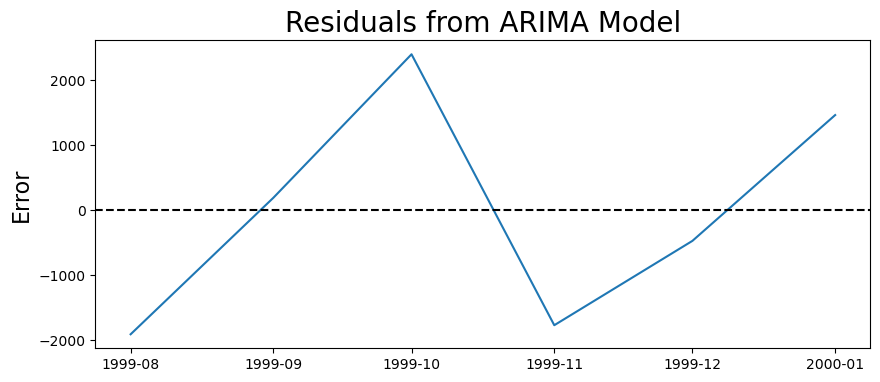

In [255]:
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Production')

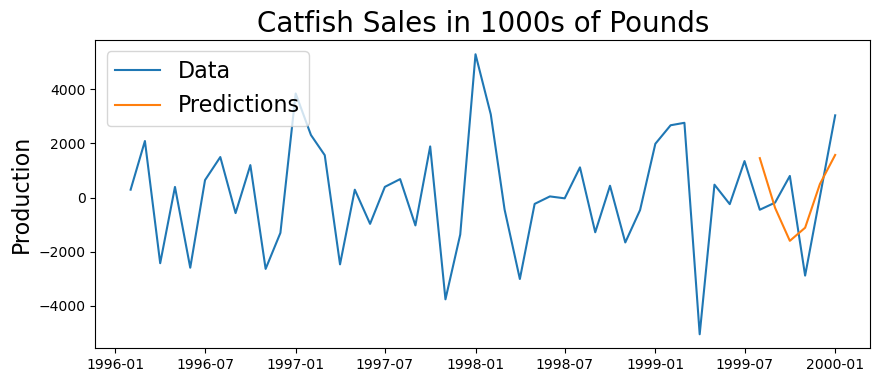

In [256]:
plt.figure(figsize=(10,4))

plt.plot(df_cat)
plt.plot(pred)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
# for year in range(df_cat.index.year[0],df_cat.index.year[-1]):
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [257]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residual/test_cat['Total'])),4))

Mean Absolute Percent Error: 4.3646


In [258]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual**2)))

Root Mean Squared Error: 1577.8146060485346


## SARIMA (Seasonal Autoregressive Integrated Moving Average) 

Is an extension of the ARIMA model that incorporates seasonality into the modeling process. It is a powerful time series forecasting technique used to analyze and predict time series data with seasonal patterns.

The SARIMA model is denoted as SARIMA(p, d, q)(P, D, Q, s), where:

    p: Order of the autoregressive (AR) component.
    d: Degree of differencing needed to make the time series stationary.
    q: Order of the moving average (MA) component.
    P: Seasonal order of the autoregressive (SAR) component.
    D: Seasonal degree of differencing.
    Q: Seasonal order of the moving average (SMA) component.
    s: Seasonal period, representing the number of observations per season.

The SARIMA model is particularly useful for time series data that exhibit both trend and seasonal components. It combines the flexibility of the ARIMA model with the ability to capture seasonal patterns. By incorporating seasonal differencing and seasonal ARMA terms, SARIMA can effectively model and forecast time series data with complex seasonal behavior.

In [259]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit the SARIMA model

my_order= (0,1,0)
my_seasonal_order= (1, 0, 1, 12)    # 12 is the Seasonal period, representing the number of observations per season
                                    # i.e 12 month in a year
# define model

sarima_model= SARIMAX(train_cat, order= my_order, seasonal_order= my_seasonal_order)

In [260]:
# fit the model
sarima_model_fit= sarima_model.fit()

In [261]:
# summary
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Total   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -372.981
Date:                              Fri, 15 Mar 2024   AIC                            751.962
Time:                                      10:48:00   BIC                            757.103
Sample:                                  02-01-1996   HQIC                           753.834
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9984      0.010    100.708      0.000       0.979       1.018
ma.S.L12      -0.9067      0.300     -3.022      0.003      -1.495      -0.319
sigma2       2.57e+06   1.27e-07   2.02e+13      0.000    2.57e+06    2.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.69   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.02   Prob(JB):                         0.46
Heteroskedasticity (H):               1.37   Skew:                            -0.45
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+28. Standard errors may be unstable.
"""

In [262]:
# get predictions and residuals
pred_sarima= sarima_model_fit.forecast(len(test_cat))
pred_sarima= pd.Series(pred_sarima, index= test_cat.index)

In [263]:
residual= test_cat['Total']- pred_sarima

Text(0, 0.5, 'Error')

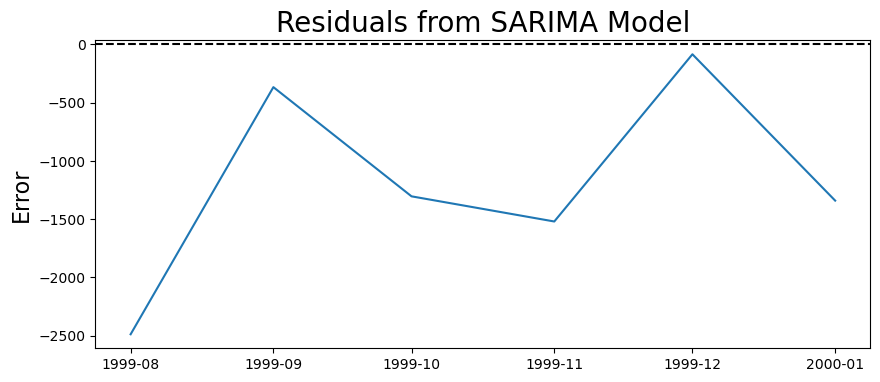

In [264]:
plt.figure(figsize=(10,4))
plt.plot(residual)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

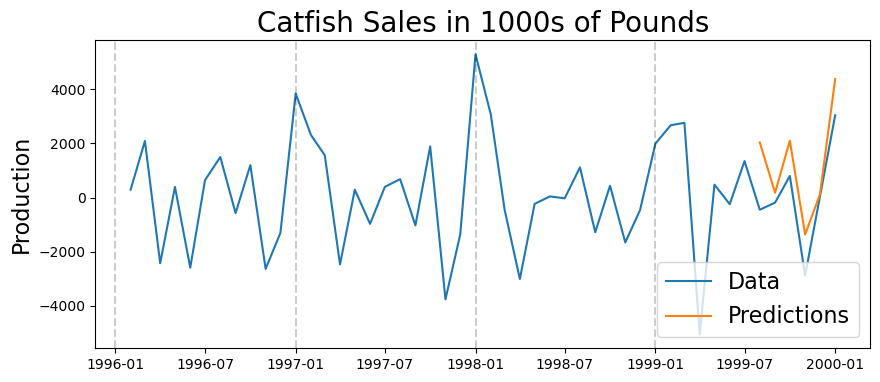

In [265]:
plt.figure(figsize=(10,4))

plt.plot(df_cat)
plt.plot(pred_sarima)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [266]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residual/test_cat['Total'])),4))

Mean Absolute Percent Error: 2.177


In [267]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residual**2)))

Root Mean Squared Error: 1422.3153165076362


### Rolling Forecast Origin

In [338]:
rolling_pred= test_cat.copy()

for train_end in test_cat.index:
    train_data= df_cat[:train_end - timedelta(days= 1)]
    model= SARIMAX(train_data, order= my_order, seasonal_order= my_seasonal_order)
    model_fit= model.fit()
    
    
    pred = model_fit.forecast()
#     print(rolling_predictions)
    rolling_pred.loc[pred.index] = pred

In [339]:
rolling_pred

,Total
Date,
1999-07-01,1087.293241
1999-08-01,2037.111769
1999-09-01,-2301.679869
1999-10-01,1711.403990
1999-11-01,-2636.708950
1999-12-01,-1414.856878
2000-01-01,4294.699729


In [340]:
rolling_residuals = test_cat - rolling_pred

In [341]:
rolling_residuals

,Total
Date,
1999-07-01,261.706759
1999-08-01,-2488.111769
1999-09-01,2113.679869
1999-10-01,-912.403990
1999-11-01,-248.291050
1999-12-01,1442.856878
2000-01-01,-1254.699729


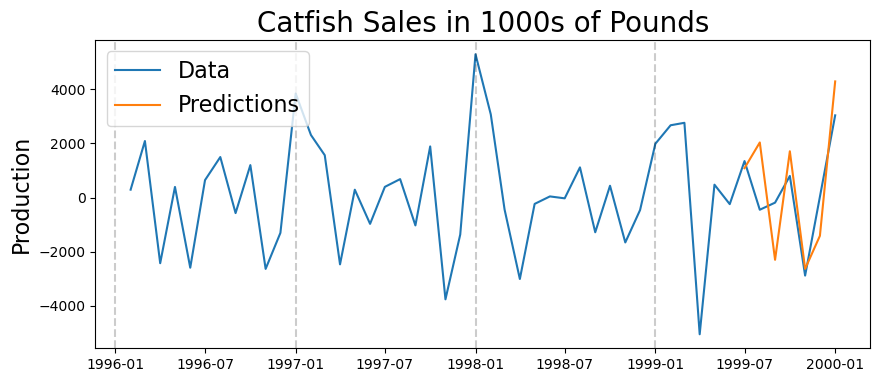

In [342]:
plt.figure(figsize=(10,4))

plt.plot(df_cat)
plt.plot(rolling_pred)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)



###  ### TO DO: Something is wrong with Rolling Forecast Model, ----check

## --------------------New data set created -----------------

In [274]:
from random import gauss

# create dataset
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.1)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

Text(0.5, 1.0, 'Simulated ARCH(2,2) Data')

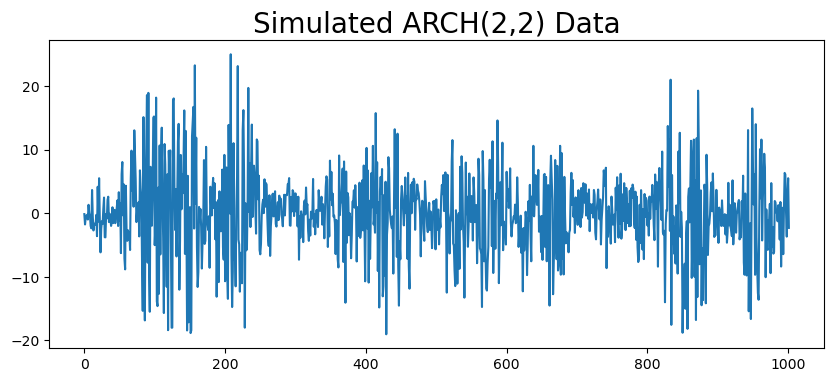

In [312]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Simulated ARCH(2,2) Data', fontsize=20)

Text(0.5, 1.0, 'Data Volatility')

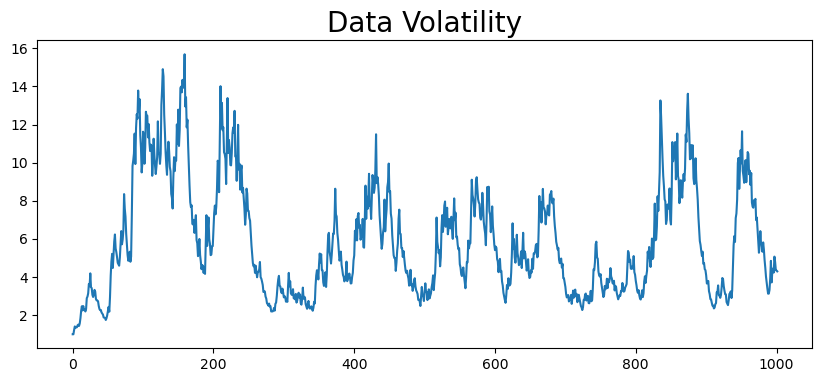

In [276]:
plt.figure(figsize=(10,4))
plt.plot(vols)
plt.title('Data Volatility', fontsize=20)

Text(0.5, 1.0, 'Data and Volatility')

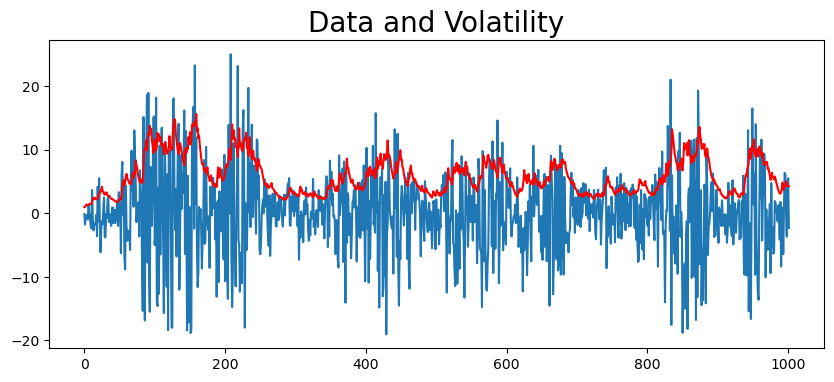

In [277]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.plot(vols, color='red')
plt.title('Data and Volatility', fontsize=20)

In [278]:
# checking volatility in catfish data by taking mean and std by month
# df_cat.groupby(df_cat.index.month==1).mean().sum(), df_cat.groupby(df_cat.index.month==2).mean().sum()

In [279]:
# df_cat.groupby(df_cat.index.month==1).std().sum() , df_cat.groupby(df_cat.index.month==2).std().sum()

### ACF

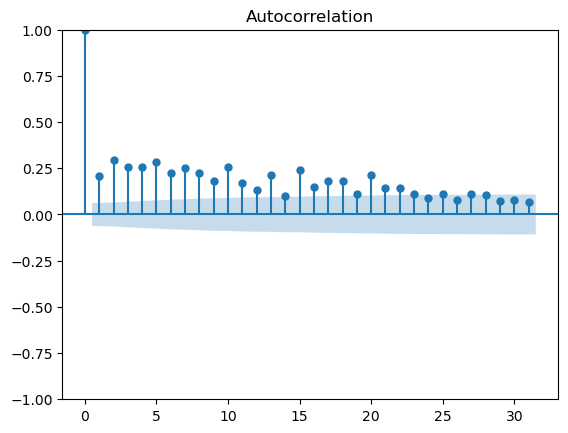

In [280]:
acf= plot_acf(np.array(series)**2)

### PACF

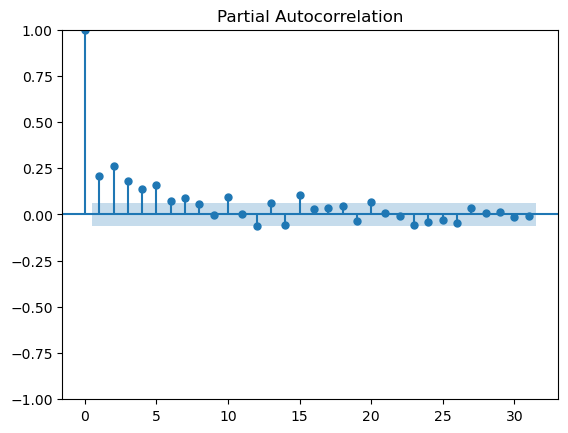

In [281]:
pacf= plot_pacf(np.array(series)**2)

In [283]:
# train test split
test_size= 100

train, test= series[:-test_size], series[-test_size:]

In [284]:
len(train), len(test)

(902, 100)

In [285]:
# ! pip install arch

###  ARCH (Autoregressive Conditional Heteroskedasticity) 

ARCH model is a type of time series model commonly used in finance and econometrics to capture the volatility clustering and time-varying volatility observed in financial returns data.

The ARCH model is specifically designed to address the issue of heteroskedasticity, which refers to the presence of time-varying volatility in the residuals of a time series model. In financial data, volatility clustering is a common phenomenon where periods of high volatility are followed by periods of high volatility, and vice versa.

In [286]:
from arch import arch_model

# define arch model
model_arch= arch_model(train, mean= 'Zero', vol= 'ARCH', p=2)

In [287]:
# fit arch model
arch_model_fit= model_arch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2947.695716995678
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2937.5245016409217
Iteration:      3,   Func. Count:     15,   Neg. LLF: 2975.1219419562512
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2904.3971741443515
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2904.3947280889042
Iteration:      6,   Func. Count:     28,   Neg. LLF: 2904.3945110268783
Iteration:      7,   Func. Count:     32,   Neg. LLF: 2904.3943820806394
Iteration:      8,   Func. Count:     35,   Neg. LLF: 2904.394382080666
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2904.3943820806394
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8


In [288]:
arch_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Zero Mean - ARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -2904.39
Distribution:                  Normal   AIC:                           5814.79
Method:            Maximum Likelihood   BIC:                           5829.20
                                        No. Observations:                  902
Date:                Fri, Mar 15 2024   Df Residuals:                      902
Time:                        10:48:03   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         21.0392      3.057      6.882  5.892e-12   [ 15.048, 27.031]
alpha[1]       0.1965  5.018e-02      3.916  9.013e-05 [9.814e-02,  0.295]
alpha[2]       0.3343  6.605e-02      5.061  4.168e-07   [  0.205,  0.464]
==========================================================================

Covariance estimator: robust
"""

In [289]:
# predict

arch_pred= arch_model_fit.forecast(horizon= test_size)

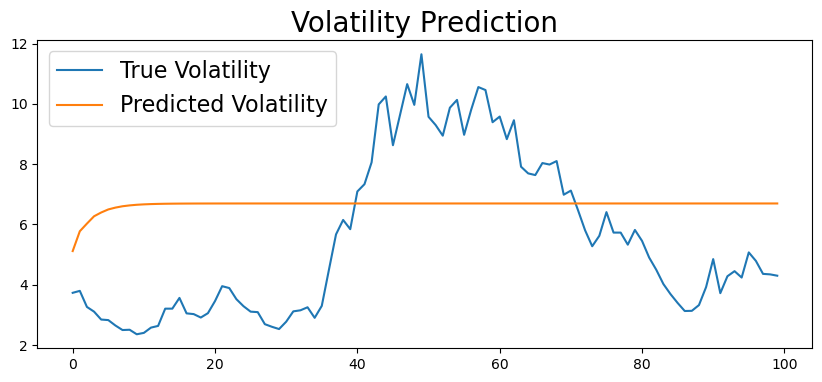

In [290]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(arch_pred.variance.values[-1, :]))
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

### Rolling Forecast Origin

In [310]:
rolling_pred= []

for i in range(test_size):
    train_data= series[:-(test_size-i)]
    model = arch_model(train_data, mean= 'Zero', vol= 'ARCH', p=7)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))

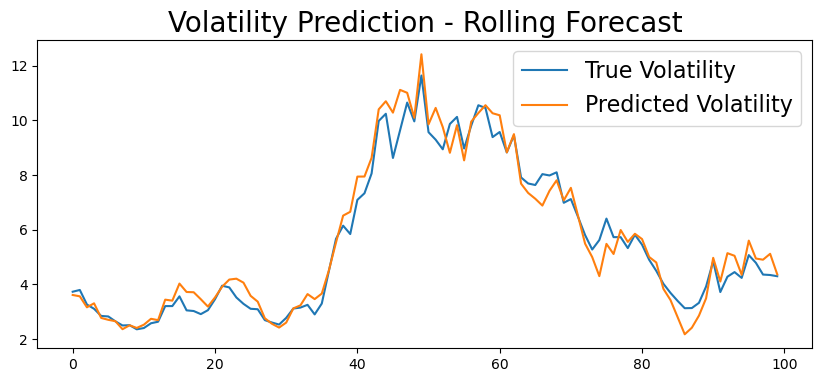

In [311]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_pred)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

## GARCH Model

The GARCH model, proposed by Tim Bollerslev in the mid-1980s, extends the ARCH model by incorporating both lagged squared residuals and lagged conditional variances in the modeling process. It includes additional parameters to capture the persistence and decay of volatility shocks over time.

The GARCH model includes parameters for both the autoregressive coefficients (ARCH terms) and the parameters representing the decay of volatility shocks over time (GARCH terms).

In [295]:
model_garch= arch_model(train, p=2, q=2, vol= 'GARCH')

In [296]:
model_garch_fit= model_garch.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 258451.4013367046
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4194.616978115175
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2851.743179498659
Iteration:      4,   Func. Count:     33,   Neg. LLF: 2833.3112462101717
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2815.832468890224
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2803.1197401724407
Iteration:      7,   Func. Count:     56,   Neg. LLF: 2811.426998522048
Iteration:      8,   Func. Count:     64,   Neg. LLF: 2811.677869697679
Iteration:      9,   Func. Count:     72,   Neg. LLF: 2802.3880599943195
Iteration:     10,   Func. Count:     79,   Neg. LLF: 2802.336462603749
Iteration:     11,   Func. Count:     86,   Neg. LLF: 2802.3348508664594
Iteration:     12,   Func. Count:     93,   Neg. LLF: 2802.3346114149413
Iteration:     13,   Func. Count:    100,   Neg. LLF: 2802.334537982869
Iteration:     14,   Func. Count:    106,   Neg. LLF: 2802.

In [297]:
model_garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2802.33
Distribution:                  Normal   AIC:                           5616.67
Method:            Maximum Likelihood   BIC:                           5645.50
                                        No. Observations:                  902
Date:                Fri, Mar 15 2024   Df Residuals:                      901
Time:                        10:52:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0293      0.147      0.200      0.842 [ -0.258,  0.317]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.8926      0.327      2.730  6.327e-03    [  0.252,  1.533]
alpha[1]       0.1064      0.102      1.040      0.298 [-9.408e-02,  0.307]
alpha[2]       0.2353  6.270e-02      3.753  1.747e-04    [  0.112,  0.358]
beta[1]    2.6615e-12      0.376  7.087e-12      1.000    [ -0.736,  0.736]
beta[2]        0.6583      0.336      1.961  4.990e-02  [2.861e-04,  1.316]
===========================================================================

Covariance estimator: robust
"""

In [298]:
# predict
garch_pred= model_garch_fit.forecast(horizon= test_size)

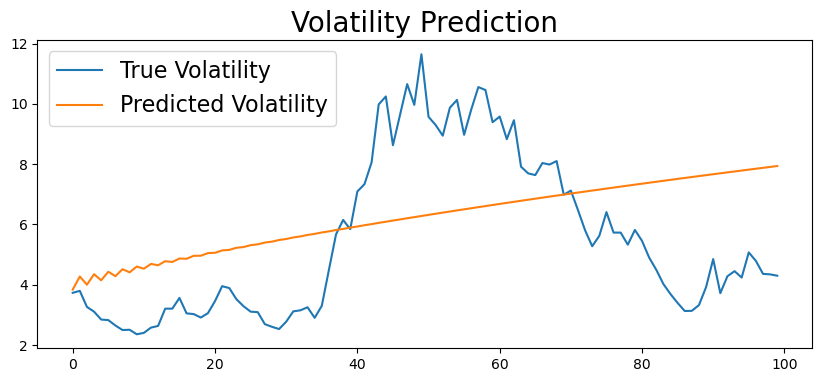

In [299]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(garch_pred.variance.values[-1, :]))
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

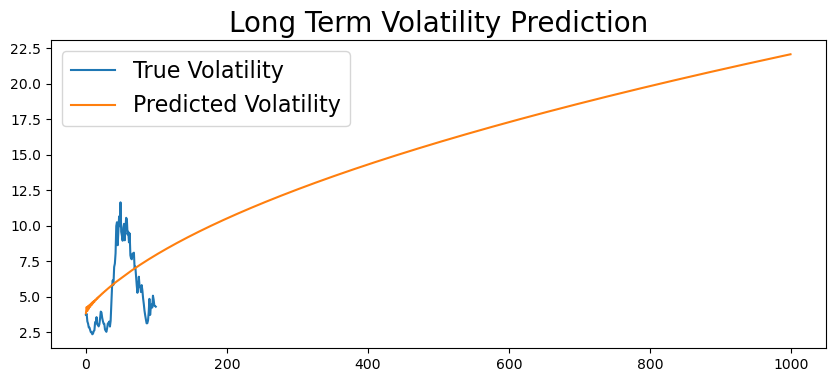

In [301]:
predictions_long_term = model_garch_fit.forecast(horizon=1000)
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(predictions_long_term.variance.values[-1, :]))
plt.title('Long Term Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [302]:
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

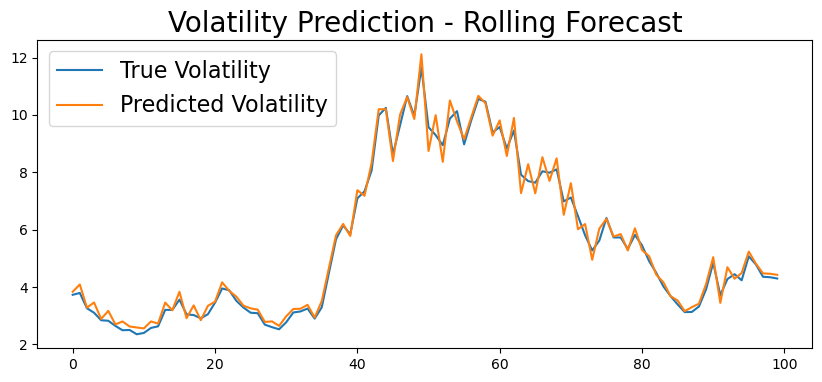

In [303]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [ ]:
# Rolling forescast gives quite accurate prediction about the volatility using GARCH model